# Histopathologic Cancer Detection

In [26]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras import layers
from matplotlib.pyplot import savefig
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.applications import VGG19, DenseNet169, DenseNet121
from tensorflow.image import crop_to_bounding_box
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [27]:
tf.__version__

'2.3.1'

In [28]:
TRAIN_PATH = "./dataset/Splitted/train/"
TEST_PATH = "./dataset/test/"
IMG_WIDTH, IMG_HEIGHT = 96, 96
# Between 1 and 220025
NUMBER_OF_SAMPLES = 200000
BATCH_SIZE = 128
FILE_NAME = str(int(NUMBER_OF_SAMPLES / 1000)) + f'K-{IMG_WIDTH}x{IMG_HEIGHT}.npy'
LOAD_MATRICES = False
USE_GENERATOR = True

In [42]:
df = pd.read_csv("./dataset/train_labels.csv")
df.head(3)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


### Check if null
We should make sure that there are no `null` fields in the dataset.
If there were any:
* Remove data row
* Fill according to other data (Which can not be done here, as the data are images)

In [43]:
number_of_empty_id_rows = len(df[df.id.isnull()])
number_of_empty_label_rows = len(df[df.label.isnull()])

if number_of_empty_id_rows == 0:
    print("[NOTE]: Dataset 'id' column has no 'Null' values. No need to fill/remove rows.")
if number_of_empty_label_rows == 0:
    print("[NOTE]: Dataset 'label' column has no 'Null' values. No need to fill/remove rows.")

[NOTE]: Dataset 'id' column has no 'Null' values. No need to fill/remove rows.
[NOTE]: Dataset 'label' column has no 'Null' values. No need to fill/remove rows.


### Understanding dataset

* Sampling positive and negative samples will help us understand the dataset.

In [ ]:
positive_tumor_samples = df[df.label == 1]
number_of_posive_tumor_samples = len(positive_tumor_samples)
number_of_posive_tumor_samples
print(f"Number of positive tumor samples: {number_of_posive_tumor_samples}")

In [ ]:
negative_tumor_samples = df[df.label == 0]
number_of_negative_tumor_samples = len(negative_tumor_samples)
number_of_negative_tumor_samples
print(f"Number of negative tumor samples: {number_of_negative_tumor_samples}")

## Data Information provided by [Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The `train_labels.csv` file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. ***A positive label indicates that the center `32x32px` region of a patch contains at least one pixel of tumor tissue.*** Tumor tissue in the outer region of the patch ***does not*** influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))

fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)

ax[0, 0].set_ylabel("Normal Tissue Samples", size='large')
ax[1, 0].set_ylabel("Positive Tumor Samples", size='large')

for i in range(5):
    # Negative Tumor Tissue Sample
    random_negative_sample = os.listdir(os.path.join(TRAIN_PATH, "0"))[random.randint(0, len(os.listdir(os.path.join(TRAIN_PATH, "0"))))]
    random_negative_sample_id = random_negative_sample.split(".")[0]
    random_negative_sample_label = "0"
    random_negative_sample_path = os.path.join(TRAIN_PATH, "0", random_negative_sample_id) + '.tif'
    random_negative_img = cv2.imread(random_negative_sample_path)
    random_negative_img = cv2.cvtColor(random_negative_img, cv2.COLOR_BGR2RGB)
    rect = patches.Rectangle((32, 32), 32, 32, linewidth=3, edgecolor='b', facecolor='none')
    ax[0, i].add_patch(rect)
    ax[0, i].imshow(random_negative_img)
    
    # Positive Tumor Tissue Samples
    random_positive_sample = os.listdir(os.path.join(TRAIN_PATH, "1"))[random.randint(0, len(os.listdir(os.path.join(TRAIN_PATH, "1"))))]
    random_positive_sample_id = random_positive_sample.split(".")[0]
    random_positive_sample_label = "1"
    random_positive_sample_path = os.path.join(TRAIN_PATH, "1", random_positive_sample_id) + '.tif'
    random_positive_img = cv2.imread(random_positive_sample_path)
    random_positive_img = cv2.cvtColor(random_positive_img, cv2.COLOR_BGR2RGB)
    rect = patches.Rectangle((32, 32), 32, 32, linewidth=3, edgecolor='r', facecolor='none')
    ax[1, i].imshow(random_positive_img)
    ax[1, i].add_patch(rect)

In [ ]:
def read_convert_images_from_df(dataframe, base_dir):
    img_list = []
    img_label_list = []
    total_number_of_data = NUMBER_OF_SAMPLES
    for index, img_datum in dataframe.iterrows():
        if index < NUMBER_OF_SAMPLES:
            print(f"{index + 1} out of {total_number_of_data}")
            print(f"Image ID: {img_datum.id}, Label: {img_datum.label}")
            img_id = img_datum.id
            img_label = df[df.id == img_id].iloc[0].label
            img_path = os.path.join(base_dir, img_id) + '.tif'
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = np.asarray(img, dtype=float)
            img /= 255.0
            img_list.append(img)
            img_label_list.append(img_label)
    return img_list, img_label_list

In [ ]:
def read_convert_images_from_path(path):
    img_list = []
    img_id_list = []
    for idx, img_name in enumerate(os.listdir(path)):
        print(f"{idx + 1} out of {NUMBER_OF_SAMPLES}")
        img_id = img_name.split(".tif")[0]
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = np.asarray(img, dtype=float)
        img /= 255.0
        img_list.append(img)
        img_id_list.append(img_id)
    img_list = np.asarray(img_list, dtype='float')
    img_id_list = np.asarray(img_id_list)
    return img_list, img_id_list

In [ ]:
def load_matrices():
    X = np.load(f'./matrices/X_{FILE_NAME}')
    y = np.load(f'./matrices/y_{FILE_NAME}')
    
    X_eval = np.load('./matrices/X_EVAL.npy')
    ID_eval = np.load('./matrices/ID_EVAL.npy')
    
    return X, y, X_eval, ID_eval

In [ ]:
if not USE_GENERATOR:
    if LOAD_MATRICES:
        X, y, X_eval, ID_eval = load_matrices()
        print(f"X Shape: {X.shape}")
        print(f"y Shape: {y.shape}")
        print(f"X eval Shape: {X_eval.shape}")
        print(f"ID eval Shape: {ID_eval.shape}")
    else:
        X, y = read_convert_images_from_df(df, TRAIN_PATH)

        X_eval, ID_eval = read_convert_images_from_path(TEST_PATH)

        X = np.asarray(X, dtype=float)
        y = np.asarray(y)

        np.save(f'./matrices/X_{FILE_NAME}', X)
        np.save(f'./matrices/y_{FILE_NAME}', y)

        np.save('./matrices/X_EVAL.npy', X_eval)
        np.save('./matrices/ID_EVAL.npy', ID_eval)

        print("X saved!")
        print("y saved!")

        print("X eval saved!")
        print("ID eval saved!")

        print(f"X Shape: {X.shape}")
        print(f"y Shape: {y.shape}")

        print(f"X eval Shape: {X_eval.shape}")
        print(f"ID eval Shape: {ID_eval.shape}")

In [ ]:
if not USE_GENERATOR:
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    print(f"X Train shape: {x_train.shape}\ny train Shape: {x_train.shape}\nX Test shape: {x_test.shape}\ny test shape: {y_test.shape}")

In [ ]:
model = Sequential([
    layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), name='input_layer'),
    layers.Dense(16, activation='relu', kernel_regularizer=L2(0.001)),
    layers.Dense(64, activation='relu'),
    layers.MaxPool2D((3, 3), padding='same'),
    layers.Dense(512, activation='relu', kernel_regularizer=L2(0.001)),
    layers.MaxPool2D((3, 3), padding='same'),
    layers.Dense(256, activation='relu'),
    layers.MaxPool2D((3, 3), padding='same'),
    layers.Dense(128, activation='relu'),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid'),
], name='Simple_CNN_16x16_200K_Tuned')

In [ ]:
if not USE_GENERATOR:
    model.summary()

In [ ]:
if not USE_GENERATOR:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [ ]:
if not USE_GENERATOR:
    history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=256, epochs=50, callbacks=[tensorboard_callback])

In [ ]:
def predict(x_test):
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    return y_pred

In [ ]:
if not USE_GENERATOR:
    y_pred_eval = predict(X_eval)

In [4]:
def plot_loss_acc(history, model_name): 
    os.mkdir(f'./plots/{model_name}')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(f'./plots/{model_name}/acc.png')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(f'./plots/{model_name}/loss.png')
    plt.show()

In [21]:
if not USE_GENERATOR:
    plot_loss_acc(history, model.name)

## Keras Image Data Generator

In [ ]:
def split_classes_for_generator(base_dir, df):
    for index, img_datum in df.iterrows():
        if index < 60000:
            dir_name = 'valid'
        else:
            dir_name = 'train'
            
        img_id = img_datum.id
        img_label = df[df.id == img_id].iloc[0].label
        img_path = os.path.join(base_dir, img_id) + '.tif'
        img_destination = f"./dataset/Splitted/{dir_name}/{str(img_label)}/{img_id}.tif"
        print(f"Copying {index + 1} out of {220000}")
        copyfile(img_path, img_destination)

In [ ]:
# split_classes_for_generator(TRAIN_PATH, df)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        './dataset/Splitted/train/',
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='binary')

In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
validation_generator = valid_datagen.flow_from_directory(
        './dataset/Splitted/valid/',
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='binary')

In [ ]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


generator_model = Sequential(name="Image_Data_Generator_Model")
generator_model.add(layers.Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
generator_model.add(layers.Conv2D(first_filters, kernel_size, activation = 'relu'))
generator_model.add(layers.Conv2D(first_filters, kernel_size, activation = 'relu'))
generator_model.add(layers.MaxPooling2D(pool_size = pool_size)) 
generator_model.add(layers.Dropout(dropout_conv))

generator_model.add(layers.Conv2D(second_filters, kernel_size, activation ='relu'))
generator_model.add(layers.Conv2D(second_filters, kernel_size, activation ='relu'))
generator_model.add(layers.Conv2D(second_filters, kernel_size, activation ='relu'))
generator_model.add(layers.MaxPooling2D(pool_size = pool_size))
generator_model.add(layers.Dropout(dropout_conv))

generator_model.add(layers.Conv2D(third_filters, kernel_size, activation ='relu'))
generator_model.add(layers.Conv2D(third_filters, kernel_size, activation ='relu'))
generator_model.add(layers.Conv2D(third_filters, kernel_size, activation ='relu'))
generator_model.add(layers.MaxPooling2D(pool_size = pool_size))
generator_model.add(layers.Dropout(dropout_conv))

generator_model.add(layers.Flatten())
generator_model.add(layers.Dense(256, activation = "relu"))
generator_model.add(layers.Dropout(dropout_dense))
generator_model.add(layers.Dense(1, activation = "sigmoid"))

In [ ]:
generator_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
generator_model.summary()

In [ ]:
filepath = "./models/model.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

In [ ]:
history = generator_model.fit(
        train_generator,
        steps_per_epoch=np.ceil(160025 / BATCH_SIZE),
        epochs=50,
        validation_data=validation_generator,
        validation_steps=np.ceil(60000 / BATCH_SIZE),
        callbacks=callbacks_list)

In [ ]:
plot_loss_acc(history, generator_model.name)

### Load Pre-trained Model

In [ ]:
model = load_model("./models/KIDG_50_epochs.h5")
print("Pre-trained model loaded successfully!")

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False)

In [ ]:
probabilities = model.predict(test_generator, verbose=1)

In [ ]:
def convert_probabilities_to_classes(probabilities):
    predicted_classes = []
    for prob in probabilities:
        if prob[0] > 0.5:
            predicted_classes.append(1)
        else:
            predicted_classes.append(0)
    return predicted_classes

In [ ]:
predicted_classes = convert_probabilities_to_classes(probabilities)

In [ ]:
def convert_filenames_to_img_id(filenames):
    for idx, img_path in enumerate(filenames):
        filenames[idx] = img_path.split(".")[0].split("/")[1]
    return filenames

In [ ]:
filenames = convert_filenames_to_img_id(test_generator.filenames)

In [ ]:
def create_and_submit_csv_file(predicted_classes, filenames):
    if os.path.exists('./submission.csv'):
        !rm submission.csv
        print("Removed old version.")

    with open('./submission.csv', 'w+') as f:
        f.write("id,label\n")
        for idx, prediction in enumerate(predicted_classes):
            f.write(f'{filenames[idx]},{prediction}\n')
        print("Submission.csv file created!")
        !./submit_csv.sh Image-Data-Generator
    return

## Crop Images

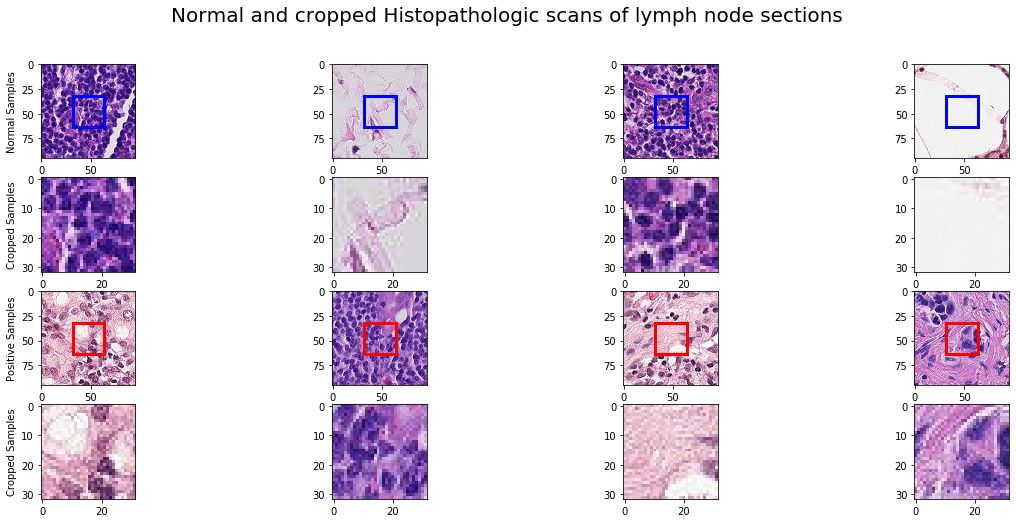

In [5]:
fig, ax = plt.subplots(4, 4, figsize=(20, 8))

fig.suptitle('Normal and cropped Histopathologic scans of lymph node sections',fontsize=20)

ax[0, 0].set_ylabel("Normal Samples")
ax[1, 0].set_ylabel("Cropped Samples")
ax[2, 0].set_ylabel("Positive Samples")
ax[3, 0].set_ylabel("Cropped Samples")

for i in range(4):
    # Negative Tumor Tissue Sample
    random_negative_sample = os.listdir(os.path.join(TRAIN_PATH, "0"))[random.randint(0, len(os.listdir(os.path.join(TRAIN_PATH, "0"))))]
    random_negative_sample_id = random_negative_sample.split(".")[0]
    random_negative_sample_label = "0"
    random_negative_sample_path = os.path.join(TRAIN_PATH, "0", random_negative_sample_id) + '.tif'
    random_negative_img = cv2.imread(random_negative_sample_path)
    random_negative_img = cv2.cvtColor(np.array(random_negative_img), cv2.COLOR_BGR2RGB)
    rect = patches.Rectangle((32, 32), 32, 32, linewidth=3, edgecolor='b', facecolor='none')
    ax[0, i].add_patch(rect)
    ax[0, i].imshow(random_negative_img)
    
    # Cropped Negative Samples
    cropped_image_tensor = crop_to_bounding_box(random_negative_img, 32, 32, 32, 32)
    ax[1, i].imshow(cropped_image_tensor)
    
    # Positive Tumor Tissue Samples
    random_positive_sample = os.listdir(os.path.join(TRAIN_PATH, "1"))[random.randint(0, len(os.listdir(os.path.join(TRAIN_PATH, "1"))))]
    random_positive_sample_id = random_positive_sample.split(".")[0]
    random_positive_sample_label = "1"
    random_positive_sample_path = os.path.join(TRAIN_PATH, "1", random_positive_sample_id) + '.tif'
    random_positive_img = cv2.imread(random_positive_sample_path)
    random_positive_img = cv2.cvtColor(np.array(random_positive_img), cv2.COLOR_BGR2RGB)
    rect = patches.Rectangle((32, 32), 32, 32, linewidth=3, edgecolor='r', facecolor='none')
    ax[2, i].imshow(random_positive_img)
    ax[2, i].add_patch(rect)
    
    # Cropped Positive Samples
    cropped_image_tensor = crop_to_bounding_box(random_positive_img, 32, 32, 32, 32)
    ax[3, i].imshow(cropped_image_tensor)

In [6]:
# create_and_submit_csv_file(predicted_classes, filenames)

In [29]:
def crop_and_save_images(path):
    for directory in os.listdir(path):
        for file_type in os.listdir(os.path.join(path, directory)):
            for idx, img_name in enumerate(os.listdir(os.path.join(path, directory, file_type))):
                print(f"{idx + 1} out of {len(os.listdir(os.path.join(path, directory)))}")
                img_path = os.path.join(path, directory, file_type, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
                cropped_image = crop_to_bounding_box(img, 32, 32, 32, 32)
                cv2.imwrite(f"./dataset/Cropped/{directory}/{file_type}/{img_name}", img)
    return

In [30]:
# crop_and_save_images("./dataset/Splitted/")

In [31]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [32]:
train_generator = train_datagen.flow_from_directory(
        './dataset/Cropped/train/',
        target_size=(32, 32),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 160025 images belonging to 2 classes.


In [33]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [34]:
validation_generator = valid_datagen.flow_from_directory(
        './dataset/Cropped/valid/',
        target_size=(32, 32),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 60000 images belonging to 2 classes.


In [41]:
# kernel_size = (3, 3)
# pool_size= (2, 2)
# first_filters = 128
# second_filters = 256
# third_filters = 32

# dropout_conv = 0.3
dropout_dense = 0.5


# generator_model = Sequential(name="Cropped_Image_Data_Generator_Model_II_100_epoch")
# generator_model.add(layers.Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (32, 32, 3)))
# generator_model.add(layers.Conv2D(first_filters, kernel_size, activation = 'relu'))
# generator_model.add(layers.Conv2D(first_filters, kernel_size, activation = 'relu'))
# # generator_model.add(layers.MaxPooling2D(pool_size = pool_size))
# generator_model.add(layers.Dropout(dropout_conv))

# generator_model.add(layers.Conv2D(second_filters, kernel_size, activation ='relu'))
# generator_model.add(layers.Conv2D(second_filters, kernel_size, activation ='relu'))
# generator_model.add(layers.Conv2D(second_filters, kernel_size, activation ='relu'))
# # generator_model.add(layers.MaxPooling2D(pool_size = pool_size))
# generator_model.add(layers.Dropout(dropout_conv))

# generator_model.add(layers.Conv2D(third_filters, kernel_size, activation ='relu'))
# generator_model.add(layers.Conv2D(third_filters, kernel_size, activation ='relu'))
# generator_model.add(layers.Conv2D(third_filters, kernel_size, activation ='relu'))
# generator_model.add(layers.MaxPooling2D(pool_size = pool_size))
# generator_model.add(layers.Dropout(dropout_conv))

# generator_model.add(layers.Conv2D(third_filters, kernel_size, activation ='relu'))
# generator_model.add(layers.Conv2D(third_filters, kernel_size, activation ='relu'))
# generator_model.add(layers.Conv2D(third_filters, kernel_size, activation ='relu'))
# # generator_model.add(layers.MaxPooling2D(pool_size = pool_size))
# generator_model.add(layers.Dropout(dropout_conv))

# generator_model.add(layers.Flatten())
# generator_model.add(layers.Dense(32, activation = "relu"))
# generator_model.add(layers.Dropout(dropout_dense))
# generator_model.add(layers.Dense(1, activation = "sigmoid"))

dense_model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling=None,
    classes=2)

model = Sequential(name='DenseNet121_100_epochs')
model.add(dense_model)

model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dense(32, activation = "relu"))
model.add(layers.Dropout(dropout_dense))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation = "relu"))
model.add(layers.Dense(1, activation = "sigmoid"))

# model.summary()

In [42]:
model.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()

Model: "DenseNet121_100_epochs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1, 1, 1024)        7037504   
_________________________________________________________________
dense_8 (Dense)              (None, 1, 1, 128)         131200    
_________________________________________________________________
dense_9 (Dense)              (None, 1, 1, 256)         33024     
_________________________________________________________________
dense_10 (Dense)             (None, 1, 1, 32)          8224      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)     

In [43]:
filepath = f"./models/{model.name}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

In [44]:
# model = load_model('./models/DenseNet169_10_epochs.h5')

In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch=np.ceil(160025 / BATCH_SIZE),
        epochs=100,
        validation_data=validation_generator,
        validation_steps=np.ceil(60000 / BATCH_SIZE),
        callbacks=callbacks_list)

Epoch 1/100
1251/1251 [==============================] - ETA: 0s - loss: 0.3861 - accuracy: 0.8300
Epoch 00001: val_accuracy improved from -inf to 0.80410, saving model to ./models/DenseNet121_100_epochs.h5
1251/1251 [==============================] - 233s 186ms/step - loss: 0.3861 - accuracy: 0.8300 - val_loss: 0.4143 - val_accuracy: 0.8041
Epoch 2/100
1251/1251 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.8777
Epoch 00002: val_accuracy improved from 0.80410 to 0.83970, saving model to ./models/DenseNet121_100_epochs.h5
1251/1251 [==============================] - 228s 183ms/step - loss: 0.2984 - accuracy: 0.8777 - val_loss: 0.3515 - val_accuracy: 0.8397
Epoch 3/100
1251/1251 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.8901
Epoch 00003: val_accuracy improved from 0.83970 to 0.84487, saving model to ./models/DenseNet121_100_epochs.h5
1251/1251 [==============================] - 228s 183ms/step - loss: 0.2709 - accuracy: 0.8901 - va

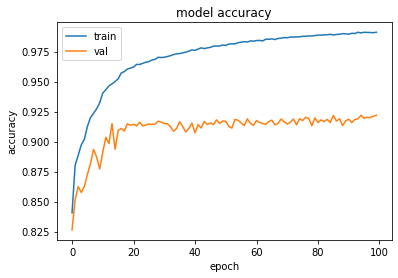

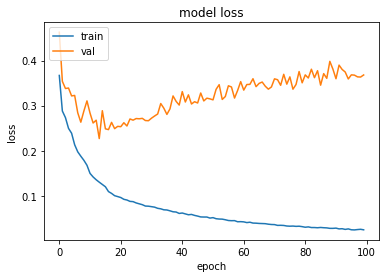

In [25]:
plot_loss_acc(history, model.name)